# Exploring Medical Narratives on Older Adult Falls

I use a custom Named Entity Recognition (NER) model to identify cause and precipitating event keywords in the narrative section of the primary data. I use the spaCy package to build the custom model. The custom keywords are organized into four major categories:

1. Method of Fall – Fall, Trip, Slip
2. Care Facility – Whether a care facility was involved.
3. Medical Event – Whether a medical event was involved.
4. Activity – Whether a particular activity was involved.

There are several reasons for selecting this approach:

1. A review of the narrative data indicates that most of the narrative is detailed in the other features (e.g. the body part, disposition, fire involvement, alcohol involvement, drug involvement and products involved). So, very few words remain and often those remaining words refer to the cause or precipitating event. The key is to identify the “cause” keywords and the NER model is an excellent method.

2. A standard or generic NER provided by a package such as spaCy does not contain the specific medical terms and other terms typically used in the narrative. In addition, the medical terms used must be very specific, so a NER pre-trained on medical terms would be problematic. For example, many of the medical terms in the narrative refer to the result of the fall (e.g. a broken arm) when we are concerned with medical events that precede the fall (e.g. fainting). Thus, a custom model will provide the best results for this specific use case.

3. Once the NER model is trained and run on the narrative, it can provide several benefits. The results can be used to categorize and detail the causes and precipitating events. The model can also be used to highlight the cause factors in the text providing more real-time feedback to those entering and using the data. Ultimately, the insights provided by the model can help make decisions on how to prevent falls.

## Import Packages and Set Data Paths 

In [1]:
import pandas as pd
import numpy as np
import json
from pathlib import Path

import spacy
from spacy import displacy
from spacy.tokens import DocBin

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Wedge

DATA_DIRECTORY = Path.cwd().parent / "data"
data_file = DATA_DIRECTORY / "primary_data.csv"
mapping_file = DATA_DIRECTORY / "variable_mapping.json"
train_file = DATA_DIRECTORY / "train.spacy"
val_file = DATA_DIRECTORY / "val.spacy"
model_file = DATA_DIRECTORY / "output/model-best"

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Load Primary Data

In [2]:
df = pd.read_csv(
    data_file,
    # set columns that can be null to nullable ints
    dtype={"body_part_2": "Int64", "diagnosis_2": "Int64"},
)
df.head(50)

,cpsc_case_number,narrative,treatment_date,age,sex,race,other_race,hispanic,diagnosis,other_diagnosis,diagnosis_2,other_diagnosis_2,body_part,body_part_2,disposition,location,fire_involvement,alcohol,drug,product_1,product_2,product_3
0,190103269,94YOM FELL TO THE FLOOR AT THE NURSING HOME ON...,2019-01-01,94,1,0,NaN,0,62,NaN,<NA>,NaN,75,<NA>,4,5,0,0,0,1807,0,0
1,190103270,86YOM FELL IN THE SHOWER AT HOME AND SUSTAINED...,2019-01-01,86,1,0,NaN,0,62,NaN,<NA>,NaN,75,<NA>,4,1,0,0,0,611,0,0
2,190103273,87YOF WAS GETTING UP FROM THE COUCH AND FELL T...,2019-01-01,87,2,0,NaN,0,53,NaN,<NA>,NaN,32,<NA>,4,1,0,0,0,679,1807,0
3,190103291,67YOF WAS AT A FRIENDS HOUSE AND SLIPPED ON WA...,2019-01-01,67,2,0,NaN,0,57,NaN,<NA>,NaN,33,<NA>,1,1,0,0,0,1807,0,0
4,190103294,70YOF WAS STANDING ON A STEP STOOL AND FELL OF...,2019-01-01,70,2,0,NaN,0,57,NaN,<NA>,NaN,33,<NA>,1,1,0,0,0,620,0,0
5,190103298,79YOM WAS STANDING ON A FOLDING LAWN CHAIR AND...,2019-01-01,79,1,0,NaN,0,52,NaN,<NA>,NaN,75,<NA>,1,1,0,0,0,4016,0,0
6,190103309,74YOM FELL INTO A PLANTER BOX AND SUSTAINED A ...,2019-01-01,74,1,0,NaN,0,57,NaN,<NA>,NaN,30,<NA>,1,1,0,0,0,1413,0,0
7,190103337,76YOF HAD A SLIP AND FALL AT HOME STRUCK HEAD ...,2019-01-01,76,2,0,NaN,0,62,NaN,<NA>,NaN,75,<NA>,1,1,0,0,0,1807,0,0
8,190103340,84YOF FELL WHILE GETTING UP FROM THE COUCH AND...,2019-01-01,84,2,0,NaN,0,53,NaN,<NA>,NaN,76,<NA>,1,1,0,0,0,679,0,0
9,190103341,88YOF FELL TO THE FLOOR AT HOME UNRESPONSIVE S...,2019-01-01,88,2,0,NaN,0,62,NaN,<NA>,NaN,75,<NA>,4,1,0,0,0,1807,0,0


## Recode the Data to Readable Form

In [3]:
with Path(mapping_file).open("r") as f:
    mapping = json.load(f, parse_int=True)
    
# convert the encoded values in the mapping to integers since they get read in as strings
for c in mapping.keys():
    mapping[c] = {int(k): v for k, v in mapping[c].items()}

for col in mapping.keys():
    df[col] = df[col].map(mapping[col])

df.head(50)

,cpsc_case_number,narrative,treatment_date,age,sex,race,other_race,hispanic,diagnosis,other_diagnosis,diagnosis_2,other_diagnosis_2,body_part,body_part_2,disposition,location,fire_involvement,alcohol,drug,product_1,product_2,product_3
0,190103269,94YOM FELL TO THE FLOOR AT THE NURSING HOME ON...,2019-01-01,94,MALE,N.S.,NaN,Unk/Not stated,62 - INTERNAL INJURY,NaN,NaN,NaN,75 - HEAD,NaN,4 - TREATED AND ADMITTED/HOSPITALIZED,PUBLIC,NO/?,No/Unk,No/Unk,1807 - FLOORS OR FLOORING MATERIALS,0 - None,0 - None
1,190103270,86YOM FELL IN THE SHOWER AT HOME AND SUSTAINED...,2019-01-01,86,MALE,N.S.,NaN,Unk/Not stated,62 - INTERNAL INJURY,NaN,NaN,NaN,75 - HEAD,NaN,4 - TREATED AND ADMITTED/HOSPITALIZED,HOME,NO/?,No/Unk,No/Unk,611 - BATHTUBS OR SHOWERS,0 - None,0 - None
2,190103273,87YOF WAS GETTING UP FROM THE COUCH AND FELL T...,2019-01-01,87,FEMALE,N.S.,NaN,Unk/Not stated,"53 - CONTUSIONS, ABR.",NaN,NaN,NaN,32 - ELBOW,NaN,4 - TREATED AND ADMITTED/HOSPITALIZED,HOME,NO/?,No/Unk,No/Unk,"679 - SOFAS, COUCHES, DAVENPORTS, DIVANS OR ST...",1807 - FLOORS OR FLOORING MATERIALS,0 - None
3,190103291,67YOF WAS AT A FRIENDS HOUSE AND SLIPPED ON WA...,2019-01-01,67,FEMALE,N.S.,NaN,Unk/Not stated,57 - FRACTURE,NaN,NaN,NaN,33 - LOWER ARM,NaN,1 - TREATED/EXAMINED AND RELEASED,HOME,NO/?,No/Unk,No/Unk,1807 - FLOORS OR FLOORING MATERIALS,0 - None,0 - None
4,190103294,70YOF WAS STANDING ON A STEP STOOL AND FELL OF...,2019-01-01,70,FEMALE,N.S.,NaN,Unk/Not stated,57 - FRACTURE,NaN,NaN,NaN,33 - LOWER ARM,NaN,1 - TREATED/EXAMINED AND RELEASED,HOME,NO/?,No/Unk,No/Unk,620 - STEP STOOLS,0 - None,0 - None
5,190103298,79YOM WAS STANDING ON A FOLDING LAWN CHAIR AND...,2019-01-01,79,MALE,N.S.,NaN,Unk/Not stated,52 - CONCUSSION,NaN,NaN,NaN,75 - HEAD,NaN,1 - TREATED/EXAMINED AND RELEASED,HOME,NO/?,No/Unk,No/Unk,4016 - BEACH CHAIRS OR FOLDING CHAIRS,0 - None,0 - None
6,190103309,74YOM FELL INTO A PLANTER BOX AND SUSTAINED A ...,2019-01-01,74,MALE,N.S.,NaN,Unk/Not stated,57 - FRACTURE,NaN,NaN,NaN,30 - SHOULDER,NaN,1 - TREATED/EXAMINED AND RELEASED,HOME,NO/?,No/Unk,No/Unk,1413 - GREENHOUSE OR GARDENING SUPPLIES,0 - None,0 - None
7,190103337,76YOF HAD A SLIP AND FALL AT HOME STRUCK HEAD ...,2019-01-01,76,FEMALE,N.S.,NaN,Unk/Not stated,62 - INTERNAL INJURY,NaN,NaN,NaN,75 - HEAD,NaN,1 - TREATED/EXAMINED AND RELEASED,HOME,NO/?,No/Unk,No/Unk,1807 - FLOORS OR FLOORING MATERIALS,0 - None,0 - None
8,190103340,84YOF FELL WHILE GETTING UP FROM THE COUCH AND...,2019-01-01,84,FEMALE,N.S.,NaN,Unk/Not stated,"53 - CONTUSIONS, ABR.",NaN,NaN,NaN,76 - FACE,NaN,1 - TREATED/EXAMINED AND RELEASED,HOME,NO/?,No/Unk,No/Unk,"679 - SOFAS, COUCHES, DAVENPORTS, DIVANS OR ST...",0 - None,0 - None
9,190103341,88YOF FELL TO THE FLOOR AT HOME UNRESPONSIVE S...,2019-01-01,88,FEMALE,N.S.,NaN,Unk/Not stated,62 - INTERNAL INJURY,NaN,NaN,NaN,75 - HEAD,NaN,4 - TREATED AND ADMITTED/HOSPITALIZED,HOME,NO/?,No/Unk,No/Unk,1807 - FLOORS OR FLOORING MATERIALS,0 - None,0 - None


## Create the Custom SpaCy NER Model Training and Validation Data

This is the heart of the NER Model where the word patterns in the narrative are given one of five labels (TRIP, SLIP, FACILITY, EVENT AND ACTIVITY).  TRIP and SLIP are two of the three methods of falls with FALL being the third method.  The word patterns were selected by simply "eyeballing" several hundered narratives and using the human brain to decide cause specific words.

The first 20,000 narratives are used as training data and the next 10,000 narratives are used as validation data.

In [4]:
#Build upon the spaCy blank model
nlp = spacy.blank("en")

#Create the EntityRuler
ruler = nlp.add_pipe("entity_ruler")

#List of Entities and Patterns
patterns = [
                {"label": "TRIP", "pattern": "TRIP"},
                {"label": "TRIP", "pattern": "TRIPPED"},
                {"label": "TRIP", "pattern": "TRIPPING"},
                {"label": "TRIP", "pattern": "T'D"},
                {"label": "TRIP", "pattern": "T'D&F"},
                {"label": "TRIP", "pattern": "T/P"},
                {"label": "TRIP", "pattern": "STUMBLE"},
                {"label": "TRIP", "pattern": "STUMBLED"},
                {"label": "TRIP", "pattern": "TANGLE"},
                {"label": "TRIP", "pattern": "TANGLED"},
                {"label": "TRIP", "pattern": "STUB"},
                {"label": "TRIP", "pattern": "STUBBED"},
    
                {"label": "SLIP", "pattern": "SLIP"},
                {"label": "SLIP", "pattern": "SLIPPED"},
                {"label": "SLIP", "pattern": "SLIPPING"},
                {"label": "SLIP", "pattern": "S'D"},
                {"label": "SLIP", "pattern": "S'D&F"},
                {"label": "SLIP", "pattern": "S/P"},
                {"label": "SLIP", "pattern": "SLID"},
                {"label": "SLIP", "pattern": "WET"},
    
                {"label": "FACILITY", "pattern": "NURSING HOME"},
                {"label": "FACILITY", "pattern": "NH"},
                {"label": "FACILITY", "pattern": "REHAB"},
                {"label": "FACILITY", "pattern": "ECF"},
                {"label": "FACILITY", "pattern": "CARE"},
                {"label": "FACILITY", "pattern": "FACILITY"},
                {"label": "FACILITY", "pattern": "GROUP HOME"},
    
                {"label": "EVENT", "pattern": "SYNCOPAL"},
                {"label": "EVENT", "pattern": "SYNCOPE"},
                {"label": "EVENT", "pattern": "DIZZY"},
                {"label": "EVENT", "pattern": "PASSED OUT"},
                {"label": "EVENT", "pattern": "ALZHEIMER"},
                {"label": "EVENT", "pattern": "ALZHEIMERS"},
                {"label": "EVENT", "pattern": "PARKINSON"},
                {"label": "EVENT", "pattern": "PARKINSONS"},
                {"label": "EVENT", "pattern": "DEMENTIA"},
                {"label": "EVENT", "pattern": "DEMENTED"},     
                {"label": "EVENT", "pattern": "LIGHTHEADED"},
                {"label": "EVENT", "pattern": "UNSTEADY"},
                {"label": "EVENT", "pattern": "SEIZURE"},
                {"label": "EVENT", "pattern": "PARKINSON"},
                {"label": "EVENT", "pattern": "BALANCE"},
    
                {"label": "ACTIVITY", "pattern": "WALKING"},
                {"label": "ACTIVITY", "pattern": "PLAYING"},
                {"label": "ACTIVITY", "pattern": "BENDING"},
                {"label": "ACTIVITY", "pattern": "WORKING"},
                {"label": "ACTIVITY", "pattern": "HIKING"},
                {"label": "ACTIVITY", "pattern": "CARRYING"},
                {"label": "ACTIVITY", "pattern": "MOWING"},
                {"label": "ACTIVITY", "pattern": "DANCING"},
                {"label": "ACTIVITY", "pattern": "ROLLERSKATING"},
                {"label": "ACTIVITY", "pattern": "SWIMMING"},
                {"label": "ACTIVITY", "pattern": "TRANSFERRING"},
                {"label": "ACTIVITY", "pattern": "LIFTING"},
                {"label": "ACTIVITY", "pattern": "FIXING"},
                {"label": "ACTIVITY", "pattern": "REACHING"},
                {"label": "ACTIVITY", "pattern": "STANDING ON"},
                {"label": "ACTIVITY", "pattern": "PICKING UP"},
                {"label": "ACTIVITY", "pattern": "PICK UP"},
                {"label": "ACTIVITY", "pattern": "GETTING UP"},
                {"label": "ACTIVITY", "pattern": "GET UP"},
                {"label": "ACTIVITY", "pattern": "GOT UP"},
                {"label": "ACTIVITY", "pattern": "GOING UP"},
                {"label": "ACTIVITY", "pattern": "GOING DOWN"},
                {"label": "ACTIVITY", "pattern": "GETTING OUT"},
                {"label": "ACTIVITY", "pattern": "GET OUT"},
                {"label": "ACTIVITY", "pattern": "GOT OUT"}
    
            ]

ruler.add_patterns(patterns)


TRAIN_DATA = []
VAL_DATA = []

#iterate over the corpus
for ind in df.index:
    text = df['narrative'][ind]
    doc = nlp(text)
    
    #remember, entities needs to be a dictionary in index 1 of the list, so it needs to be an empty list
    entities = []
    
    #extract entities
    for ent in doc.ents:

        #appending to entities in the correct format
        entities.append([ent.start_char, ent.end_char, ent.label_])
    
    # Use first 20,000 entries for training and next 10,000 entries for validation
    if entities:
        if ind <= 20000:
            TRAIN_DATA.append([text, {"entities": entities}])
        elif (ind > 20000) & (ind <= 30000):
            VAL_DATA.append([text, {"entities": entities}])
        else:
            break

## Display the First 100 Entries with Highlighted Patterns

One of the strong features of a NER model is the ability to apply it directly to the narrative text to highlight the named enitities and their associated label.  This could be used to highlight the cause factors in the text providing more real-time feedback to those entering and using the data.

In [5]:
%%capture --no-display
for ind in df.index:
    text = df['narrative'][ind]
    doc = nlp(text)
    displacy.render(doc, style="ent")
    if ind > 500:
        break  

## Convert the Data to SpaCy Format

The data needs to be convereted to SpaCy format and saved to disk.

In [6]:
def convert(lang: str, TRAIN_DATA, output_path: Path):
    nlp = spacy.blank(lang)
    db = DocBin()
    for text, annot in TRAIN_DATA:
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label)
            if span is None:
                msg = f"Skipping entity [{start}, {end}, {label}] in the following text because the character span '{doc.text[start:end]}' does not align with token boundaries:\n\n{repr(text)}\n"
                warnings.warn(msg)
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    db.to_disk(output_path)

convert("en", TRAIN_DATA, train_file)
convert("en", VAL_DATA, val_file)

## The Following Steps Need to Occur in the Terminal (1st Time Only)

In [7]:
# Create config file and train model in terminal using the stored training and validation data.
# These steps are difficult to do in a notebook as specific configurations are machine and environment specific.

# See https://spacy.io/usage/training

# python -m spacy init fill-config base_config.cfg config.cfg
# python -m spacy train config.cfg --output ./output --paths.train ./train.spacy --paths.dev ./val.spacy

## Load Custom Trained NER Model

In [8]:
trained_nlp = spacy.load(model_file)

## Test on a Single Entry

In [9]:
text = "89YOF WAS SITTING ON THE EDGE OF HER BED WHEN SHE SLIPPED AND FELL ONTO HER BACK. DX: COMPRESSION FX OF VERTEBRA'"
doc = trained_nlp(text)

for ent in doc.ents:
    print (ent.text, ent.label_)

SLIPPED SLIP


## Iterate Over the Primary Data and Categorize into Four Categories

Iterate over all the primary data using the trained model categorizing each entry into four categories. Remember, TRIP and SLIP are in the method category.  Scroll right on the dataframe to see the four new features added to the dataframe.

In [10]:
#iterate over the corpus
df['method'] = ''
df['facility'] = ''
df['event'] = ''
df['activity'] = ''
for ind in df.index:
    text = df['narrative'][ind]
    doc = trained_nlp(text)
    
    #extract entities
    for ent in doc.ents:
        if ind < 100:
            print (ind, ent.text, ent.label_)
        if ent.label_ == 'TRIP':
            df.at[ind, 'method'] = ent.label_
        if ent.label_ == 'SLIP':
            df.at[ind, 'method'] = ent.label_
        if ent.label_ == 'FACILITY':
            df.at[ind, 'facility'] = ent.text
        if ent.label_ == 'EVENT':
            df.at[ind, 'event'] = ent.text
        if ent.label_ == 'ACTIVITY':
            df.at[ind, 'activity'] = ent.text

0 NURSING HOME FACILITY
2 GETTING UP ACTIVITY
3 SLIPPED SLIP
4 STANDING ON ACTIVITY
5 STANDING ON ACTIVITY
7 SLIP SLIP
8 GETTING UP ACTIVITY
10 GOING DOWN ACTIVITY
11 SLIP SLIP
11 NH FACILITY
12 NH FACILITY
12 SLIP SLIP
14 DANCING ACTIVITY
15 NH FACILITY
16 SLIP SLIP
16 ALZHEIMERS EVENT
17 S/P SLIP
18 S/P SLIP
19 S/P SLIP
19 SLIPPED SLIP
20 S/P SLIP
21 S/P SLIP
22 S/P SLIP
23 S/P SLIP
23 SYNCOPAL EVENT
24 S/P SLIP
24 NURSING HOME FACILITY
25 NURSING HOME FACILITY
27 SYNCOPAL EVENT
27 SYNCOPE EVENT
29 GETTING OUT ACTIVITY
30 WALKING ACTIVITY
32 NURSING HOME FACILITY
33 GETTING OUT ACTIVITY
33 SLIP SLIP
36 PICKING UP ACTIVITY
37 TRIPPED TRIP
38 NH FACILITY
39 NH FACILITY
40 SYNCOPAL EVENT
42 T'D&F TRIP
42 WALKING ACTIVITY
42 CARRYING ACTIVITY
45 S/P SLIP
45 SLIPPED SLIP
46 S/P SLIP
47 S/P SLIP
47 TRIP TRIP
48 S/P SLIP
49 S/P SLIP
50 TRIPPED TRIP
52 WALKING ACTIVITY
52 TRIPPED TRIP
53 DIZZY EVENT
54 S/P SLIP
54 CARE FACILITY
55 DIZZY EVENT
55 SYNCOPE EVENT
58 STUBBED TRIP
59 NH FACILITY
6

In [11]:
df.head(50)

,cpsc_case_number,narrative,treatment_date,age,sex,race,other_race,hispanic,diagnosis,other_diagnosis,diagnosis_2,other_diagnosis_2,body_part,body_part_2,disposition,location,fire_involvement,alcohol,drug,product_1,product_2,product_3,method,facility,event,activity
0,190103269,94YOM FELL TO THE FLOOR AT THE NURSING HOME ON...,2019-01-01,94,MALE,N.S.,NaN,Unk/Not stated,62 - INTERNAL INJURY,NaN,NaN,NaN,75 - HEAD,NaN,4 - TREATED AND ADMITTED/HOSPITALIZED,PUBLIC,NO/?,No/Unk,No/Unk,1807 - FLOORS OR FLOORING MATERIALS,0 - None,0 - None,,NURSING HOME,,
1,190103270,86YOM FELL IN THE SHOWER AT HOME AND SUSTAINED...,2019-01-01,86,MALE,N.S.,NaN,Unk/Not stated,62 - INTERNAL INJURY,NaN,NaN,NaN,75 - HEAD,NaN,4 - TREATED AND ADMITTED/HOSPITALIZED,HOME,NO/?,No/Unk,No/Unk,611 - BATHTUBS OR SHOWERS,0 - None,0 - None,,,,
2,190103273,87YOF WAS GETTING UP FROM THE COUCH AND FELL T...,2019-01-01,87,FEMALE,N.S.,NaN,Unk/Not stated,"53 - CONTUSIONS, ABR.",NaN,NaN,NaN,32 - ELBOW,NaN,4 - TREATED AND ADMITTED/HOSPITALIZED,HOME,NO/?,No/Unk,No/Unk,"679 - SOFAS, COUCHES, DAVENPORTS, DIVANS OR ST...",1807 - FLOORS OR FLOORING MATERIALS,0 - None,,,,GETTING UP
3,190103291,67YOF WAS AT A FRIENDS HOUSE AND SLIPPED ON WA...,2019-01-01,67,FEMALE,N.S.,NaN,Unk/Not stated,57 - FRACTURE,NaN,NaN,NaN,33 - LOWER ARM,NaN,1 - TREATED/EXAMINED AND RELEASED,HOME,NO/?,No/Unk,No/Unk,1807 - FLOORS OR FLOORING MATERIALS,0 - None,0 - None,SLIP,,,
4,190103294,70YOF WAS STANDING ON A STEP STOOL AND FELL OF...,2019-01-01,70,FEMALE,N.S.,NaN,Unk/Not stated,57 - FRACTURE,NaN,NaN,NaN,33 - LOWER ARM,NaN,1 - TREATED/EXAMINED AND RELEASED,HOME,NO/?,No/Unk,No/Unk,620 - STEP STOOLS,0 - None,0 - None,,,,STANDING ON
5,190103298,79YOM WAS STANDING ON A FOLDING LAWN CHAIR AND...,2019-01-01,79,MALE,N.S.,NaN,Unk/Not stated,52 - CONCUSSION,NaN,NaN,NaN,75 - HEAD,NaN,1 - TREATED/EXAMINED AND RELEASED,HOME,NO/?,No/Unk,No/Unk,4016 - BEACH CHAIRS OR FOLDING CHAIRS,0 - None,0 - None,,,,STANDING ON
6,190103309,74YOM FELL INTO A PLANTER BOX AND SUSTAINED A ...,2019-01-01,74,MALE,N.S.,NaN,Unk/Not stated,57 - FRACTURE,NaN,NaN,NaN,30 - SHOULDER,NaN,1 - TREATED/EXAMINED AND RELEASED,HOME,NO/?,No/Unk,No/Unk,1413 - GREENHOUSE OR GARDENING SUPPLIES,0 - None,0 - None,,,,
7,190103337,76YOF HAD A SLIP AND FALL AT HOME STRUCK HEAD ...,2019-01-01,76,FEMALE,N.S.,NaN,Unk/Not stated,62 - INTERNAL INJURY,NaN,NaN,NaN,75 - HEAD,NaN,1 - TREATED/EXAMINED AND RELEASED,HOME,NO/?,No/Unk,No/Unk,1807 - FLOORS OR FLOORING MATERIALS,0 - None,0 - None,SLIP,,,
8,190103340,84YOF FELL WHILE GETTING UP FROM THE COUCH AND...,2019-01-01,84,FEMALE,N.S.,NaN,Unk/Not stated,"53 - CONTUSIONS, ABR.",NaN,NaN,NaN,76 - FACE,NaN,1 - TREATED/EXAMINED AND RELEASED,HOME,NO/?,No/Unk,No/Unk,"679 - SOFAS, COUCHES, DAVENPORTS, DIVANS OR ST...",0 - None,0 - None,,,,GETTING UP
9,190103341,88YOF FELL TO THE FLOOR AT HOME UNRESPONSIVE S...,2019-01-01,88,FEMALE,N.S.,NaN,Unk/Not stated,62 - INTERNAL INJURY,NaN,NaN,NaN,75 - HEAD,NaN,4 - TREATED AND ADMITTED/HOSPITALIZED,HOME,NO/?,No/Unk,No/Unk,1807 - FLOORS OR FLOORING MATERIALS,0 - None,0 - None,,,,


## Fill the Method Feature with Fall for Blank Entries (Not a Trip or Slip)

For the method featured, if the field is neither a SLIP or TRIP it is a FALL.

In [12]:
df['method'] = df['method'].replace('', 'FALL')
df.head(50)

,cpsc_case_number,narrative,treatment_date,age,sex,race,other_race,hispanic,diagnosis,other_diagnosis,diagnosis_2,other_diagnosis_2,body_part,body_part_2,disposition,location,fire_involvement,alcohol,drug,product_1,product_2,product_3,method,facility,event,activity
0,190103269,94YOM FELL TO THE FLOOR AT THE NURSING HOME ON...,2019-01-01,94,MALE,N.S.,NaN,Unk/Not stated,62 - INTERNAL INJURY,NaN,NaN,NaN,75 - HEAD,NaN,4 - TREATED AND ADMITTED/HOSPITALIZED,PUBLIC,NO/?,No/Unk,No/Unk,1807 - FLOORS OR FLOORING MATERIALS,0 - None,0 - None,FALL,NURSING HOME,,
1,190103270,86YOM FELL IN THE SHOWER AT HOME AND SUSTAINED...,2019-01-01,86,MALE,N.S.,NaN,Unk/Not stated,62 - INTERNAL INJURY,NaN,NaN,NaN,75 - HEAD,NaN,4 - TREATED AND ADMITTED/HOSPITALIZED,HOME,NO/?,No/Unk,No/Unk,611 - BATHTUBS OR SHOWERS,0 - None,0 - None,FALL,,,
2,190103273,87YOF WAS GETTING UP FROM THE COUCH AND FELL T...,2019-01-01,87,FEMALE,N.S.,NaN,Unk/Not stated,"53 - CONTUSIONS, ABR.",NaN,NaN,NaN,32 - ELBOW,NaN,4 - TREATED AND ADMITTED/HOSPITALIZED,HOME,NO/?,No/Unk,No/Unk,"679 - SOFAS, COUCHES, DAVENPORTS, DIVANS OR ST...",1807 - FLOORS OR FLOORING MATERIALS,0 - None,FALL,,,GETTING UP
3,190103291,67YOF WAS AT A FRIENDS HOUSE AND SLIPPED ON WA...,2019-01-01,67,FEMALE,N.S.,NaN,Unk/Not stated,57 - FRACTURE,NaN,NaN,NaN,33 - LOWER ARM,NaN,1 - TREATED/EXAMINED AND RELEASED,HOME,NO/?,No/Unk,No/Unk,1807 - FLOORS OR FLOORING MATERIALS,0 - None,0 - None,SLIP,,,
4,190103294,70YOF WAS STANDING ON A STEP STOOL AND FELL OF...,2019-01-01,70,FEMALE,N.S.,NaN,Unk/Not stated,57 - FRACTURE,NaN,NaN,NaN,33 - LOWER ARM,NaN,1 - TREATED/EXAMINED AND RELEASED,HOME,NO/?,No/Unk,No/Unk,620 - STEP STOOLS,0 - None,0 - None,FALL,,,STANDING ON
5,190103298,79YOM WAS STANDING ON A FOLDING LAWN CHAIR AND...,2019-01-01,79,MALE,N.S.,NaN,Unk/Not stated,52 - CONCUSSION,NaN,NaN,NaN,75 - HEAD,NaN,1 - TREATED/EXAMINED AND RELEASED,HOME,NO/?,No/Unk,No/Unk,4016 - BEACH CHAIRS OR FOLDING CHAIRS,0 - None,0 - None,FALL,,,STANDING ON
6,190103309,74YOM FELL INTO A PLANTER BOX AND SUSTAINED A ...,2019-01-01,74,MALE,N.S.,NaN,Unk/Not stated,57 - FRACTURE,NaN,NaN,NaN,30 - SHOULDER,NaN,1 - TREATED/EXAMINED AND RELEASED,HOME,NO/?,No/Unk,No/Unk,1413 - GREENHOUSE OR GARDENING SUPPLIES,0 - None,0 - None,FALL,,,
7,190103337,76YOF HAD A SLIP AND FALL AT HOME STRUCK HEAD ...,2019-01-01,76,FEMALE,N.S.,NaN,Unk/Not stated,62 - INTERNAL INJURY,NaN,NaN,NaN,75 - HEAD,NaN,1 - TREATED/EXAMINED AND RELEASED,HOME,NO/?,No/Unk,No/Unk,1807 - FLOORS OR FLOORING MATERIALS,0 - None,0 - None,SLIP,,,
8,190103340,84YOF FELL WHILE GETTING UP FROM THE COUCH AND...,2019-01-01,84,FEMALE,N.S.,NaN,Unk/Not stated,"53 - CONTUSIONS, ABR.",NaN,NaN,NaN,76 - FACE,NaN,1 - TREATED/EXAMINED AND RELEASED,HOME,NO/?,No/Unk,No/Unk,"679 - SOFAS, COUCHES, DAVENPORTS, DIVANS OR ST...",0 - None,0 - None,FALL,,,GETTING UP
9,190103341,88YOF FELL TO THE FLOOR AT HOME UNRESPONSIVE S...,2019-01-01,88,FEMALE,N.S.,NaN,Unk/Not stated,62 - INTERNAL INJURY,NaN,NaN,NaN,75 - HEAD,NaN,4 - TREATED AND ADMITTED/HOSPITALIZED,HOME,NO/?,No/Unk,No/Unk,1807 - FLOORS OR FLOORING MATERIALS,0 - None,0 - None,FALL,,,


## Code for Ishikawa Diagram

Ishikawa diagrams are used to identify problems in a system by showing how causes and effects are linked.  The code for the Ishikawa diagram was derived from matplotlib:
https://matplotlib.org/devdocs/gallery/specialty_plots/ishikawa_diagram.html

In [13]:
def problems(data: str,
             problem_x: float, problem_y: float,
             prob_angle_x: float, prob_angle_y: float):
    """
    Draw each problem section of the Ishikawa plot.

    Parameters
    ----------
    data : str
        The category name.
    problem_x, problem_y : float, optional
        The `X` and `Y` positions of the problem arrows (`Y` defaults to zero).
    prob_angle_x, prob_angle_y : float, optional
        The angle of the problem annotations. They are angled towards
        the tail of the plot.

    Returns
    -------
    None.

    """
    ax.annotate(str.upper(data), xy=(problem_x, problem_y),
                xytext=(prob_angle_x, prob_angle_y),
                fontsize='10',
                color='white',
                weight='bold',
                xycoords='data',
                verticalalignment='center',
                horizontalalignment='center',
                textcoords='offset fontsize',
                arrowprops=dict(arrowstyle="->", facecolor='black'),
                bbox=dict(boxstyle='square',
                          facecolor='tab:blue',
                          pad=0.8))


def causes(data: list, cause_x: float, cause_y: float,
           cause_xytext=(-9, -0.3), top: bool = True):
    """
    Place each cause to a position relative to the problems
    annotations.

    Parameters
    ----------
    data : indexable object
        The input data. IndexError is
        raised if more than six arguments are passed.
    cause_x, cause_y : float
        The `X` and `Y` position of the cause annotations.
    cause_xytext : tuple, optional
        Adjust to set the distance of the cause text from the problem
        arrow in fontsize units.
    top : bool

    Returns
    -------
    None.

    """
    for index, cause in enumerate(data):
        # First cause annotation is placed in the middle of the problems arrow
        # and each subsequent cause is plotted above or below it in succession.

        # [<x pos>, [<y pos top>, <y pos bottom>]]
        coords = [[0, [0, 0]],
                  [0.23, [0.5, -0.5]],
                  [-0.46, [-1, 1]],
                  [0.69, [1.5, -1.5]],
                  [-0.92, [-2, 2]],
                  [1.15, [2.5, -2.5]]]
        if top:
            cause_y += coords[index][1][0]
        else:
            cause_y += coords[index][1][1]
        cause_x -= coords[index][0]

        ax.annotate(cause, xy=(cause_x, cause_y),
                    horizontalalignment='center',
                    xytext=cause_xytext,
                    fontsize='9',
                    xycoords='data',
                    textcoords='offset fontsize',
                    arrowprops=dict(arrowstyle="->",
                                    facecolor='black'))


def draw_body(data: dict, fish_head: str):
    """
    Place each section in its correct place by changing
    the coordinates on each loop.

    Parameters
    ----------
    data : dict
        The input data (can be list or tuple). ValueError is
        raised if more than six arguments are passed.
    fish_head : str
        The heading string.

    Returns
    -------
    None.

    """
    second_sections = []
    third_sections = []
    # Resize diagram to automatically scale in response to the number
    # of problems in the input data.
    if len(data) == 1 or len(data) == 2:
        spine_length = (-2.1, 2)
        head_pos = (2, 0)
        tail_pos = ((-2.8, 0.8), (-2.8, -0.8), (-2.0, -0.01))
        first_section = [1.6, 0.8]
    elif len(data) == 3 or len(data) == 4:
        spine_length = (-3.1, 3)
        head_pos = (3, 0)
        tail_pos = ((-3.8, 0.8), (-3.8, -0.8), (-3.0, -0.01))
        first_section = [2.6, 1.8]
        second_sections = [-0.4, -1.2]
    else:  # len(data) == 5 or 6
        spine_length = (-4.1, 4)
        head_pos = (4, 0)
        tail_pos = ((-4.8, 0.8), (-4.8, -0.8), (-4.0, -0.01))
        first_section = [3.5, 2.7]
        second_sections = [1, 0.2]
        third_sections = [-1.5, -2.3]

    # Change the coordinates of the annotations on each loop.
    for index, problem in enumerate(data.values()):
        top_row = True
        cause_arrow_y = 1.7
        if index % 2 != 0:  # Plot problems below the spine.
            top_row = False
            y_prob_angle = -16
            cause_arrow_y = -1.7
        else:  # Plot problems above the spine.
            y_prob_angle = 16
        # Plot the 3 sections in pairs along the main spine.
        if index in (0, 1):
            prob_arrow_x = first_section[0]
            cause_arrow_x = first_section[1]
        elif index in (2, 3):
            prob_arrow_x = second_sections[0]
            cause_arrow_x = second_sections[1]
        else:
            prob_arrow_x = third_sections[0]
            cause_arrow_x = third_sections[1]
        if index > 5:
            raise ValueError(f'Maximum number of problems is 6, you have entered '
                             f'{len(data)}')

        # draw main spine
        ax.plot(spine_length, [0, 0], color='tab:blue', linewidth=2)
        # draw fish head
        ax.text(head_pos[0] + 0.1, head_pos[1] - 0.05, fish_head, fontsize=10,
                weight='bold', color='white')
        semicircle = Wedge(head_pos, 1, 270, 90, fc='tab:blue')
        ax.add_patch(semicircle)
        # draw fishtail
        triangle = Polygon(tail_pos, fc='tab:blue')
        ax.add_patch(triangle)
        # Pass each category name to the problems function as a string on each loop.
        problems(list(data.keys())[index], prob_arrow_x, 0, -12, y_prob_angle)
        # Start the cause function with the first annotation being plotted at
        # the cause_arrow_x, cause_arrow_y coordinates.
        causes(problem, cause_arrow_x, cause_arrow_y, top=top_row)

## Create Diagram Text

The create_str procedure creates the text used in spines of the Ishikawa diagram.

In [14]:
def create_str(df, col, keywords, title):
    '''
    Input:
        df - a dataframe
        col - a column of the dataframe
        keywords - the keywords to group together
        title - the title to use on the diagram
    Output:
        f_str - a string
    '''
    n = 0
    
    val_len = len(df[col].value_counts().index)
    if val_len < 20:
        iterations = val_len
    else:
        iterations = 20
    
    for i in range(iterations):
        if df[col].value_counts().index[i] in keywords:
            n = n + df[col].value_counts().iloc[i]
    
    n_pct = int(n / len(df.index) * 100)
    f_str = title + ' - ' + str(n_pct) + '%'
    return f_str

## Code to Categorize the Falls

The create_categories procedure creates a dictionary consisting of category headings and lists of spine strings.  The categories dictionary is then used to render the Ishikawa diagram.

In [15]:
def create_categories(df):
    '''
    Input:
        df - a dataframe
    Output:
        categories - a dictionary of category headings and their corresponding spine strings
    '''
    
    # Alcohol/Drug Category
    a_pct = int((len(df.index) - df['alcohol'].value_counts().iloc[0]) / len(df.index) * 100)
    d_pct = int((len(df.index) - df['drug'].value_counts().iloc[0]) / len(df.index) * 100)
    ad_pct = a_pct + d_pct
    ad_str = 'Alcohol/Drug - ' + str(ad_pct) + '%'
    
    alcohol_str = create_str(df, 'alcohol', ['Yes'], 'Alcohol')
    drug_str = create_str(df, 'drug', ['Yes'], 'Drug')
    
    alcohol_drug = [alcohol_str, drug_str]

    # Fire Category
    fire_str = create_str(df, 'fire_involvement', ['FD'], 'Fire')
    fire_involvement = [fire_str]
    
    # Activity Category
    act_pct = int((len(df.index) - df['activity'].value_counts().iloc[0]) / len(df.index) * 100)
    act_str = 'Activity - ' + str(act_pct) + '%'

    walking_str = create_str(df, 'activity', ['WALKING', 'HIKING', 'GOING UP', 'GOING DOWN'], 'Walking/Hiking')
    getup_str = create_str(df, 'activity', ['GETTING OUT', 'GETTING UP', 'GET UP', 'GOT UP', 'GET OUT', 'GOT OUT'], \
                           'Getting Up/Out')
    carrying_str = create_str(df, 'activity', ['CARRYING', 'BENDING', 'PICKING UP', 'LIFTING', 'REACHING'], 'Carrying/Bending')
    playing_str = create_str(df, 'activity', ['PLAYING', 'WORKING', 'SWIMMING', 'DANCING', 'MOWING', 'FIXING'], \
                             'Playing/Working')

    activities = [carrying_str, getup_str, playing_str, walking_str]
    
    # Facility Category
    fac_pct = int((len(df.index) - df['facility'].value_counts().iloc[0]) / len(df.index) * 100)
    fac_str = 'Facility - ' + str(fac_pct) + '%'

    other_str = create_str(df, 'facility', ['FACILITY'], 'Other Facility')
    extended_str = create_str(df, 'facility', ['ECF', 'CARE'], 'Ext. Care Facility')
    nursing_str = create_str(df, 'facility', ['NURSING HOME', 'NH'], \
                             'Nursing Home')

    facilities = [other_str, nursing_str, extended_str]
    
    # Event Category
    event_pct = int((len(df.index) - df['event'].value_counts().iloc[0]) / len(df.index) * 100)
    event_str = 'Medical Event - ' + str(event_pct) + '%'

    bal_str = create_str(df, 'event', ['BALANCE', 'UNSTEADY'], 'Lost Balance')
    dement_str = create_str(df, 'event', ['DEMENTIA', 'DEMENTED'], 'Dementia')
    faint_str = create_str(df, 'event', ['SYNCOPE', 'DIZZY', 'PASSED OUT', 'SYNCOPAL', 'LIGHTHEADED'], 'Fainting')

    events = [bal_str, dement_str, faint_str]
    
    # Product Category
    product_series = pd.concat([df['product_1'], df['product_2'], df['product_3']])
    frame = {'product': product_series}
    all_products = pd.DataFrame(frame)

    total_prods = len(all_products.index)
    prods_less_floors = total_prods - all_products['product'].value_counts().iloc[1]
    product_pct = int((prods_less_floors - all_products['product'].value_counts().iloc[0]) / prods_less_floors * 100)
    # product_pct = int(((len(df.index) * 3) - all_products['product'].value_counts().iloc[0]) / (len(df.index) * 3) * 100)
    product_str = 'Products - ' + str(product_pct) + '%'

    floors_str = create_str(all_products, 'product', ['676 - RUGS OR CARPETS, NOT SPECIFIED'], 'Rugs/Carpets')
    beds_str = create_str(all_products, 'product', ['4076 - BEDS OR BEDFRAMES, OTHER OR NOT SPECIFIED'], 'Beds')
    stairs_str = create_str(all_products, 'product', ['1842 - STAIRS OR STEPS'], 'Stairs')
    chairs_str = create_str(all_products, 'product', ['4074 - CHAIRS, OTHER OR NOT SPECIFIED'], 'Chairs')
    baths_str = create_str(all_products, 'product', ['611 - BATHTUBS OR SHOWERS', '649 - TOILETS'], 'Baths/Showers')

    products = [stairs_str, baths_str, beds_str, chairs_str, floors_str]
    
    # Create the fishbone diagram
    header = 'FALLS'

    categories = {
        fac_str: facilities,
        event_str: events,
        act_str: activities,
        product_str: products,
        ad_str: alcohol_drug,
        fire_str: fire_involvement
    }

    draw_body(categories, header)
    plt.show()
    return categories

## Code to Convert Result from Dictionary to Dataframe

The convert procedure converts the category dictionary to an ordered dataframe.  It is used to create the top ten cause rankings.

In [16]:
def convert(cat_dict):
    '''
    Input:
        cat_dict - a dictionary of category headings and their corresponding spine strings
    Output:
        final - a dataframe ordered by descending percentages
    '''
    cause_list = []
    pct_list = []
    cause_dict = {}

    for k, v in cat_dict.items():
        end = k.rfind('-') - 1
        header = k[0:end]
        for i in range(len(v)):
            detail = v[i]
            end = detail.rfind('-')
            name = detail[0:end]
            start = end + 1
            pct = int(detail[start:-1])
            cause = header + ' - ' + name
            cause_list.append(cause)
            pct_list.append(pct)

    cause_dict['cause'] = cause_list
    cause_dict['pct'] = pct_list
    result = pd.DataFrame.from_dict(cause_dict)
    result = result.sort_values(by=['pct'], ascending=False)
    final = result.reset_index(drop=True)
    return final

## Results

The final results are summarized at the end of the analysis, but let's take a look at the individual results.

###  Breakdown of Falls by Fall, Trip and Slip

The type of falls can be broken down into slips (15%), trips (16%) and other falls (67%).

In [17]:
df['method'].value_counts(normalize=True)

method
FALL    0.685958
TRIP    0.159813
SLIP    0.154228
Name: proportion, dtype: float64

### Breakdown of Falls by Facility (.1% or More)

While the location feature shows that about 60% of all falls occur at home, 38% occur in the non-descriptive PUBLIC or UNK locations.  The facility feature extracts the type of care facility involved in the fall from the narrative.  Home falls are excluded from causes as the environment is under the control of the patient.  Care facilities, however, can contribute to falls as they involve factors out of the control of the patient such as maintenance and staffing. 

In [18]:
df['location'].value_counts(normalize=True)

location
HOME      0.604501
PUBLIC    0.189146
UNK       0.186219
SPORTS    0.016338
STREET    0.002979
SCHOOL    0.000400
MOBILE    0.000269
INDST.    0.000078
FARM      0.000069
Name: proportion, dtype: float64

In [19]:
df['facility'].value_counts(normalize=True).loc[lambda x : x>.001]

facility
                0.895612
NURSING HOME    0.053558
NH              0.022610
FACILITY        0.013324
ECF             0.008643
CARE            0.002484
REHAB           0.002111
GROUP HOME      0.001477
Name: proportion, dtype: float64

### Breakdown of Falls by Event (.1% or More)

About 13% of all falls involve a medical event.

In [20]:
df['event'].value_counts(normalize=True).loc[lambda x : x>.001]

event
               0.869033
BALANCE        0.049614
SYNCOPE        0.034388
DIZZY          0.013333
DEMENTIA       0.008087
PASSED OUT     0.006714
SYNCOPAL       0.005403
SEIZURE        0.003509
DEMENTED       0.003136
LIGHTHEADED    0.002814
PARKINSON      0.001555
UNSTEADY       0.001077
Name: proportion, dtype: float64

### Breakdown of Falls by Activity (.1 or More)

About 22% of all falls involve an activity.

In [21]:
df['activity'].value_counts(normalize=True).loc[lambda x : x>.001]

activity
                0.779941
WALKING         0.075064
GETTING OUT     0.033163
GET UP          0.012873
GETTING UP      0.012829
CARRYING        0.009581
GOT UP          0.008634
REACHING        0.008347
GET OUT         0.007418
PLAYING         0.006931
GOING DOWN      0.005403
TRANSFERRING    0.005377
STANDING ON     0.005307
PICK UP         0.005116
GOING UP        0.004994
BENDING         0.003388
WORKING         0.002979
HIKING          0.002614
GOT OUT         0.002441
SWIMMING        0.001511
DANCING         0.001407
PICKING UP      0.001060
Name: proportion, dtype: float64

### Breakdown of Falls by Product (.1% or More)

While about 13% of all falls involve floors, they have been excluded from causes in this analysis as the narratives clearly show that in the vast majority of cases the floors are what the patient hits upon falling.  Falls that involve floors are accounted for in this analysis as slips or trips.  Also rugs and carpets are still included as products. 

In [22]:
product_series = pd.concat([df['product_1'], df['product_2'], df['product_3']])
frame = {'product': product_series}
all_products = pd.DataFrame(frame)
all_products['product'].value_counts(normalize=True).loc[lambda x : x>.001]

product
0 - None                                                               0.570869
1807 - FLOORS OR FLOORING MATERIALS                                    0.134433
4076 - BEDS OR BEDFRAMES, OTHER OR NOT SPECIFIED                       0.046429
1842 - STAIRS OR STEPS                                                 0.040028
4074 - CHAIRS, OTHER OR NOT SPECIFIED                                  0.019986
611 - BATHTUBS OR SHOWERS                                              0.014920
649 - TOILETS                                                          0.012531
4057 - TABLES (EXCL.  BABY CHANGING TABLES, BILLIARD OR POOL TABLES    0.011819
676 - RUGS OR CARPETS, NOT SPECIFIED                                   0.010716
1884 - CEILINGS AND WALLS (INTERIOR PART OF COMPLETED STRUCTURE)       0.009919
1615 - FOOTWEAR                                                        0.007794
4078 - LADDERS, OTHER OR NOT SPECIFIED                                 0.005909
1817 - PORCHES, BALCONIES, OPEN-

### Diagram Showing Causes for All Falls

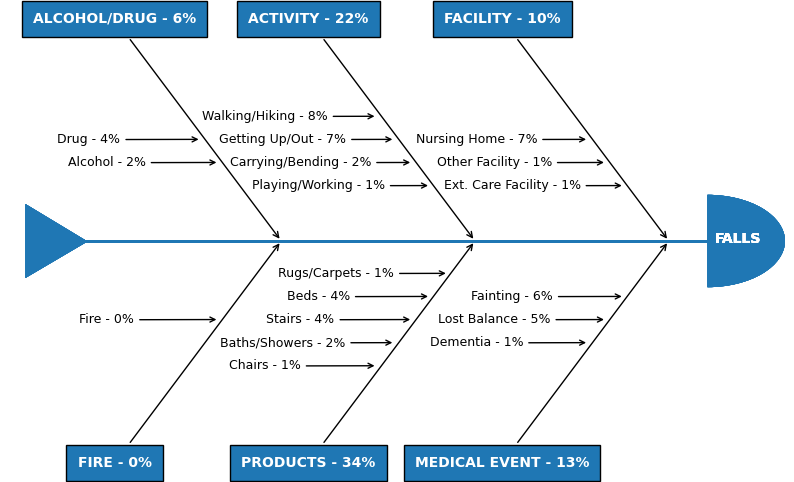

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.axis('off')

all_cats = create_categories(df)

### All Falls - Top Ten Causes

In [24]:
all_causes = convert(all_cats)
all_causes.head(10)

,cause,pct
0,Activity - Walking/Hiking,8
1,Activity - Getting Up/Out,7
2,Facility - Nursing Home,7
3,Medical Event - Fainting,6
4,Medical Event - Lost Balance,5
5,Alcohol/Drug - Drug,4
6,Products - Stairs,4
7,Products - Beds,4
8,Alcohol/Drug - Alcohol,2
9,Activity - Carrying/Bending,2


### Diagram Showing Causes of Falls Due to Slipping

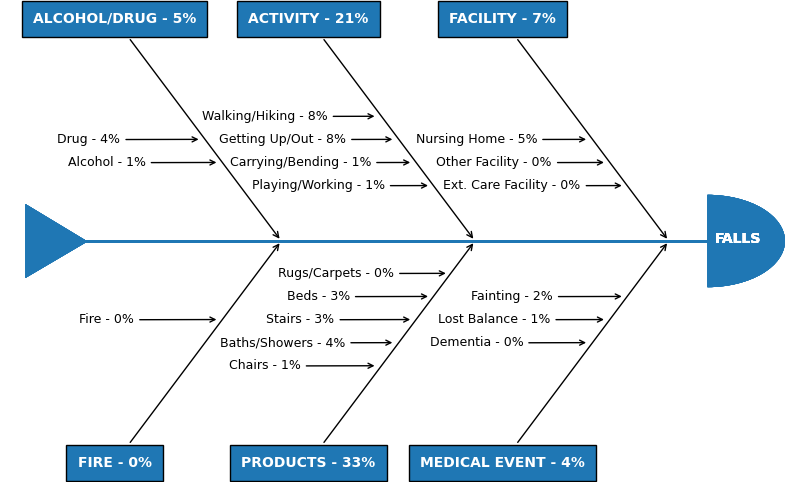

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.axis('off')

slip_df = df[df['method'] == 'SLIP']
slip_cats = create_categories(slip_df)

### Slips - Top Ten Causes

In [26]:
slip_causes = convert(slip_cats)
slip_causes.head(10)

,cause,pct
0,Activity - Walking/Hiking,8
1,Activity - Getting Up/Out,8
2,Facility - Nursing Home,5
3,Alcohol/Drug - Drug,4
4,Products - Baths/Showers,4
5,Products - Stairs,3
6,Products - Beds,3
7,Medical Event - Fainting,2
8,Medical Event - Lost Balance,1
9,Alcohol/Drug - Alcohol,1


### Diagram Showing Causes of Falls Due to Tripping

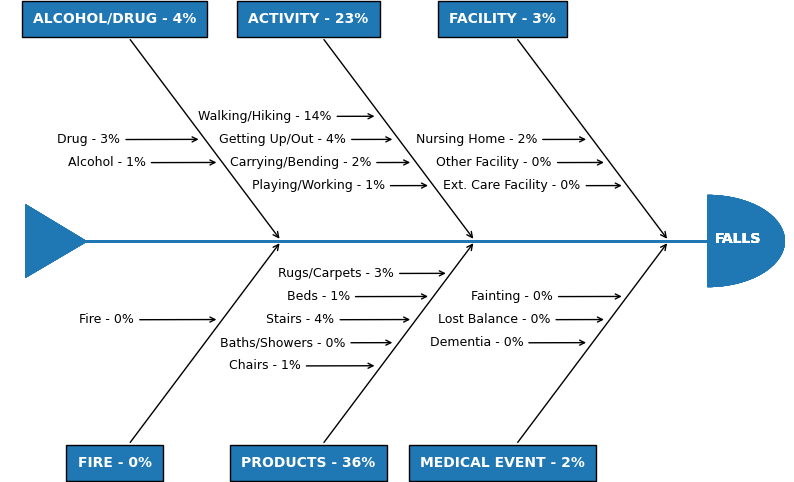

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.axis('off')

trip_df = df[df['method'] == 'TRIP']
trip_cats = create_categories(trip_df)

### Trips - Top Ten Causes

In [28]:
trip_causes = convert(trip_cats)
trip_causes.head(10)

,cause,pct
0,Activity - Walking/Hiking,14
1,Activity - Getting Up/Out,4
2,Products - Stairs,4
3,Alcohol/Drug - Drug,3
4,Products - Rugs/Carpets,3
5,Activity - Carrying/Bending,2
6,Facility - Nursing Home,2
7,Products - Beds,1
8,Alcohol/Drug - Alcohol,1
9,Products - Chairs,1


### Diagram Showing Causes of Falls Due to Falling Excluding Slipping and Tripping

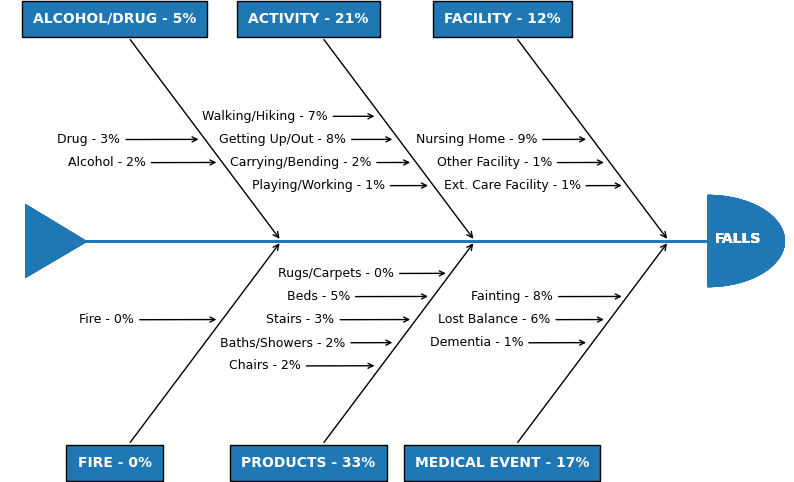

In [29]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.axis('off')

fall_df = df[df['method'] == 'FALL']
fall_cats = create_categories(fall_df)

### Falls Only - Top Ten Causes

In [30]:
fall_causes = convert(fall_cats)
fall_causes.head(10)

,cause,pct
0,Facility - Nursing Home,9
1,Medical Event - Fainting,8
2,Activity - Getting Up/Out,8
3,Activity - Walking/Hiking,7
4,Medical Event - Lost Balance,6
5,Products - Beds,5
6,Alcohol/Drug - Drug,3
7,Products - Stairs,3
8,Alcohol/Drug - Alcohol,2
9,Activity - Carrying/Bending,2


### Diagram Showing Causes of Serious Injuries for All Falls

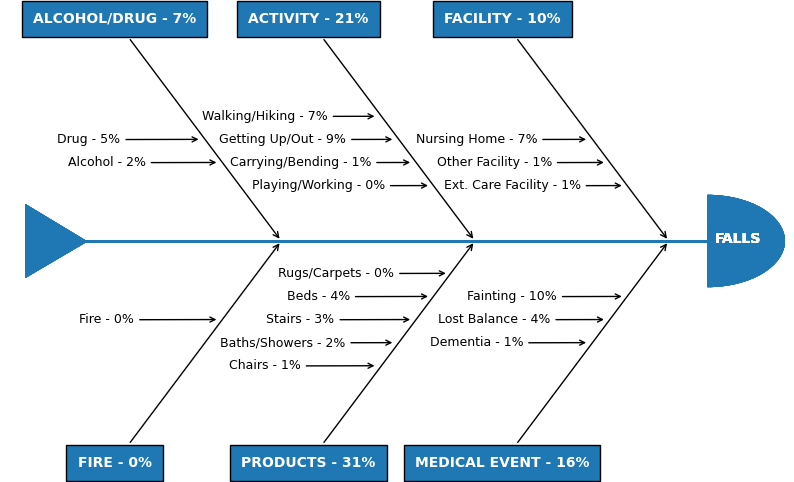

In [31]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.axis('off')

severe_df = df[(df['disposition'] == '4 - TREATED AND ADMITTED/HOSPITALIZED') | \
               (df['disposition'] == '2 - TREATED AND TRANSFERRED') ]
serious_cats = create_categories(severe_df)

### Serious Injuries - Top Ten Causes

In [32]:
serious_causes = convert(serious_cats)
serious_causes.head(10)

,cause,pct
0,Medical Event - Fainting,10
1,Activity - Getting Up/Out,9
2,Activity - Walking/Hiking,7
3,Facility - Nursing Home,7
4,Alcohol/Drug - Drug,5
5,Medical Event - Lost Balance,4
6,Products - Beds,4
7,Products - Stairs,3
8,Products - Baths/Showers,2
9,Alcohol/Drug - Alcohol,2


### Diagram Showing Causes of All Falls for Males

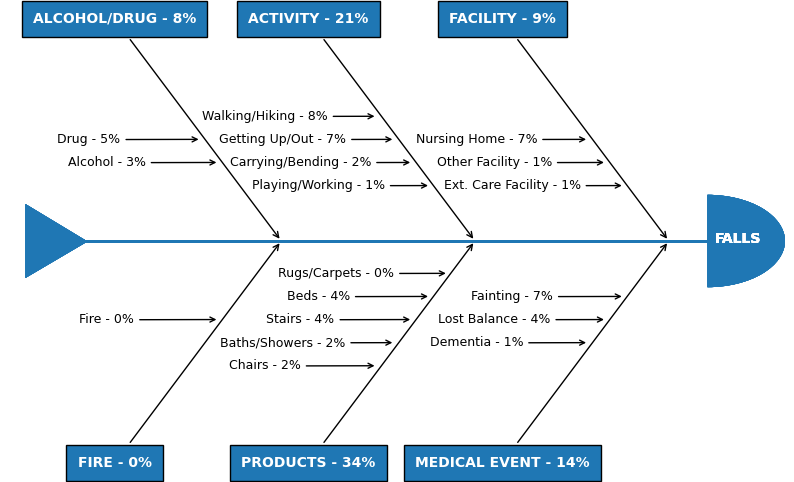

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.axis('off')

male_df = df[df['sex'] == 'MALE']
male_cats = create_categories(male_df)

### Male Falls - Top Ten Causes

In [34]:
male_causes = convert(male_cats)
male_causes.head(10)

,cause,pct
0,Activity - Walking/Hiking,8
1,Medical Event - Fainting,7
2,Activity - Getting Up/Out,7
3,Facility - Nursing Home,7
4,Alcohol/Drug - Drug,5
5,Products - Beds,4
6,Medical Event - Lost Balance,4
7,Products - Stairs,4
8,Alcohol/Drug - Alcohol,3
9,Activity - Carrying/Bending,2


### Diagram Showing Causes of All Falls for Females

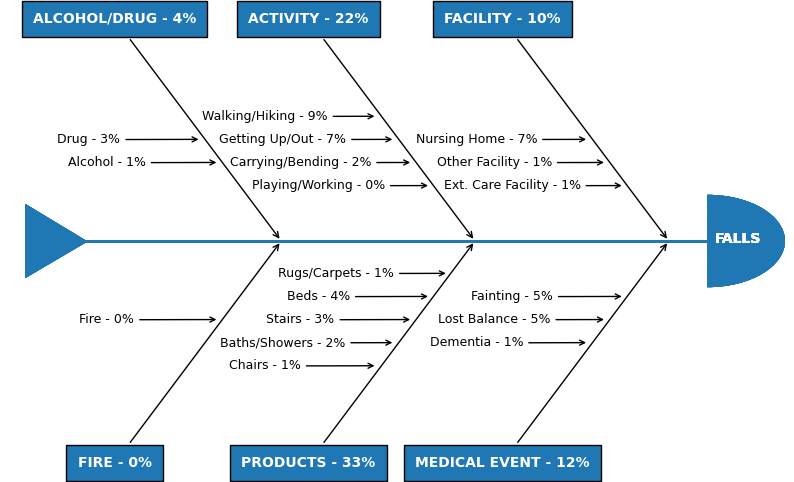

In [35]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.axis('off')

female_df = df[df['sex'] == 'FEMALE']
female_cats = create_categories(female_df)

### Female Falls - Top Ten Causes

In [36]:
female_causes = convert(female_cats)
female_causes.head(10)

,cause,pct
0,Activity - Walking/Hiking,9
1,Activity - Getting Up/Out,7
2,Facility - Nursing Home,7
3,Medical Event - Lost Balance,5
4,Medical Event - Fainting,5
5,Products - Beds,4
6,Alcohol/Drug - Drug,3
7,Products - Stairs,3
8,Activity - Carrying/Bending,2
9,Products - Baths/Showers,2


### Diagram Showing Causes of All Falls for Ages 60-69

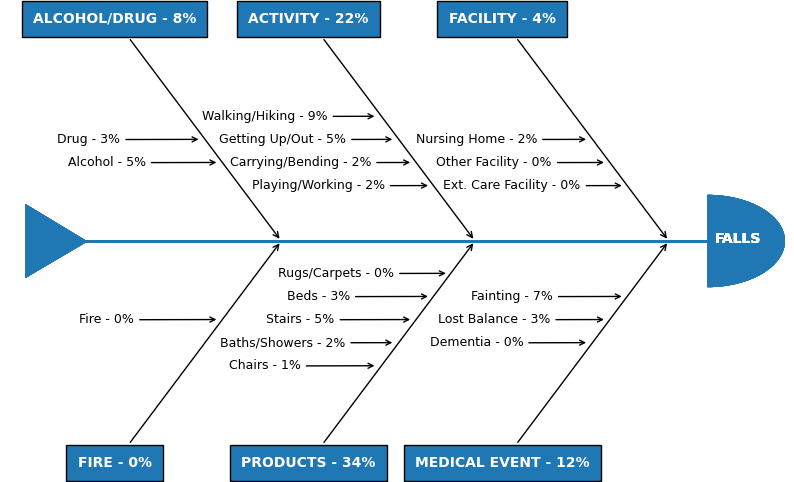

In [37]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.axis('off')

df_60_69 = df[df['age'] < 70]
cats_60_69 = create_categories(df_60_69)

### Age 60-69 Falls - Top Ten Causes

In [38]:
causes_60_69 = convert(cats_60_69)
causes_60_69.head(10)

,cause,pct
0,Activity - Walking/Hiking,9
1,Medical Event - Fainting,7
2,Alcohol/Drug - Alcohol,5
3,Activity - Getting Up/Out,5
4,Products - Stairs,5
5,Alcohol/Drug - Drug,3
6,Medical Event - Lost Balance,3
7,Products - Beds,3
8,Activity - Carrying/Bending,2
9,Activity - Playing/Working,2


### Diagram Showing Causes of All Falls for Ages 70-79

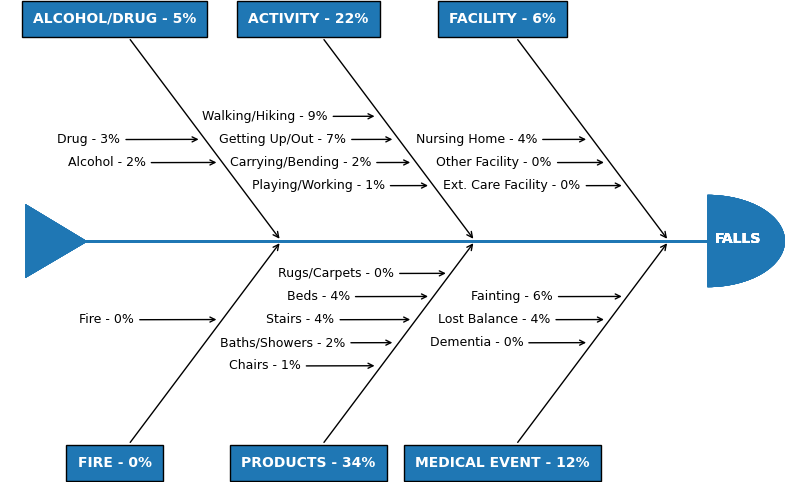

In [39]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.axis('off')

df_70_79 = df[(df['age'] >= 70) & (df['age'] <= 79)]
cats_70_79 = create_categories(df_70_79)

### Age 70-79 Falls - Top Ten Causes

In [40]:
causes_70_79 = convert(cats_70_79)
causes_70_79.head(10)

,cause,pct
0,Activity - Walking/Hiking,9
1,Activity - Getting Up/Out,7
2,Medical Event - Fainting,6
3,Medical Event - Lost Balance,4
4,Facility - Nursing Home,4
5,Products - Stairs,4
6,Products - Beds,4
7,Alcohol/Drug - Drug,3
8,Alcohol/Drug - Alcohol,2
9,Activity - Carrying/Bending,2


### Diagram Showing Causes of All Falls for Ages 80-89

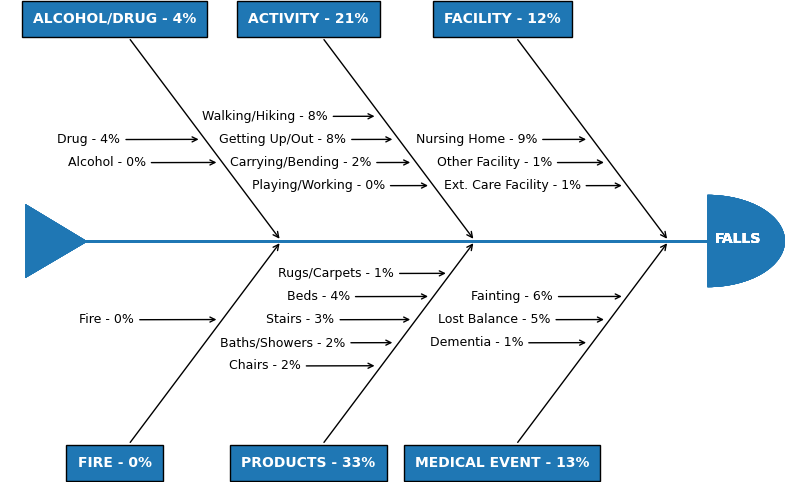

In [41]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.axis('off')

df_80_89 = df[(df['age'] >= 80) & (df['age'] <= 89)]
cats_80_89 = create_categories(df_80_89)

### Age 80-89 Falls - Top Ten Causes

In [42]:
causes_80_89 = convert(cats_80_89)
causes_80_89.head(10)

,cause,pct
0,Facility - Nursing Home,9
1,Activity - Walking/Hiking,8
2,Activity - Getting Up/Out,8
3,Medical Event - Fainting,6
4,Medical Event - Lost Balance,5
5,Products - Beds,4
6,Alcohol/Drug - Drug,4
7,Products - Stairs,3
8,Activity - Carrying/Bending,2
9,Products - Chairs,2


### Diagram Showing Causes of All Falls for Ages 90+

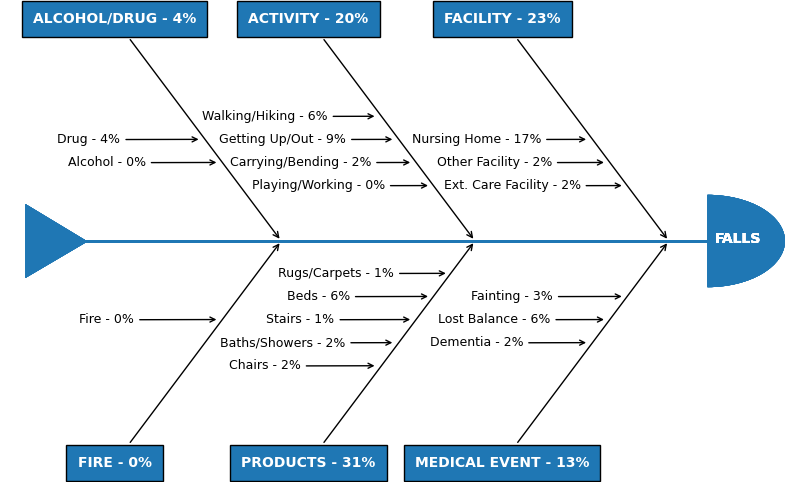

In [43]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.axis('off')

df_90 = df[df['age'] > 89]
cats_90 = create_categories(df_90)

### Age 90+ Falls - Top Ten Causes

In [44]:
causes_90 = convert(cats_90)
causes_90.head(10)

,cause,pct
0,Facility - Nursing Home,17
1,Activity - Getting Up/Out,9
2,Activity - Walking/Hiking,6
3,Medical Event - Lost Balance,6
4,Products - Beds,6
5,Alcohol/Drug - Drug,4
6,Medical Event - Fainting,3
7,Products - Chairs,2
8,Products - Baths/Showers,2
9,Facility - Other Facility,2


### Diagram Showing Causes of All Falls for Whites

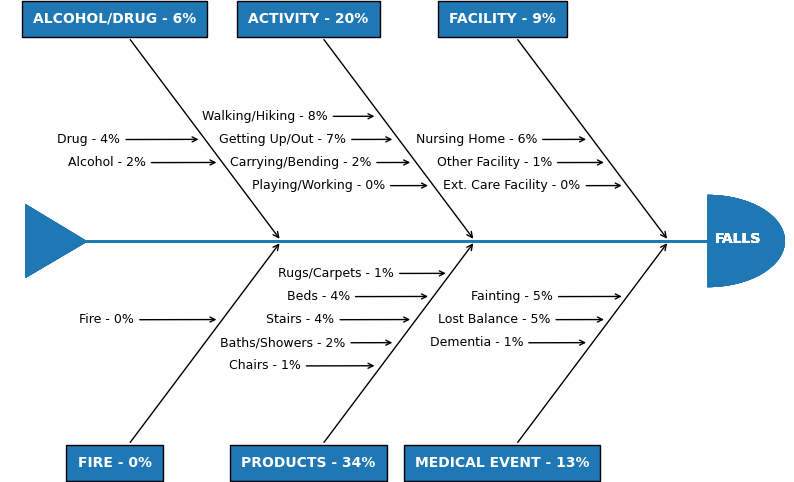

In [45]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.axis('off')

white_df = df[df['race'] == 'WHITE']
white_cats = create_categories(white_df)

### Race White Falls - Top Ten Causes

In [46]:
white_causes = convert(white_cats)
white_causes.head(10)

,cause,pct
0,Activity - Walking/Hiking,8
1,Activity - Getting Up/Out,7
2,Facility - Nursing Home,6
3,Medical Event - Lost Balance,5
4,Medical Event - Fainting,5
5,Alcohol/Drug - Drug,4
6,Products - Stairs,4
7,Products - Beds,4
8,Alcohol/Drug - Alcohol,2
9,Activity - Carrying/Bending,2


### Diagram Showing Causes of All Falls for Blacks

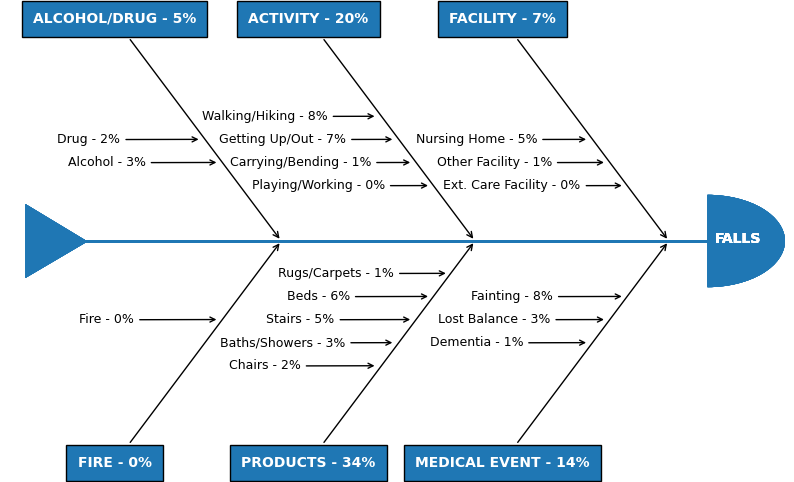

In [47]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.axis('off')

black_df = df[df['race'] == 'BLACK/AFRICAN AMERICAN']
black_cats = create_categories(black_df)

### Race Black Falls - Top Ten Causes

In [48]:
black_causes = convert(black_cats)
black_causes.head(10)

,cause,pct
0,Activity - Walking/Hiking,8
1,Medical Event - Fainting,8
2,Activity - Getting Up/Out,7
3,Products - Beds,6
4,Facility - Nursing Home,5
5,Products - Stairs,5
6,Medical Event - Lost Balance,3
7,Alcohol/Drug - Alcohol,3
8,Products - Baths/Showers,3
9,Alcohol/Drug - Drug,2


### Diagram Showing Causes of All Falls for Hispanics

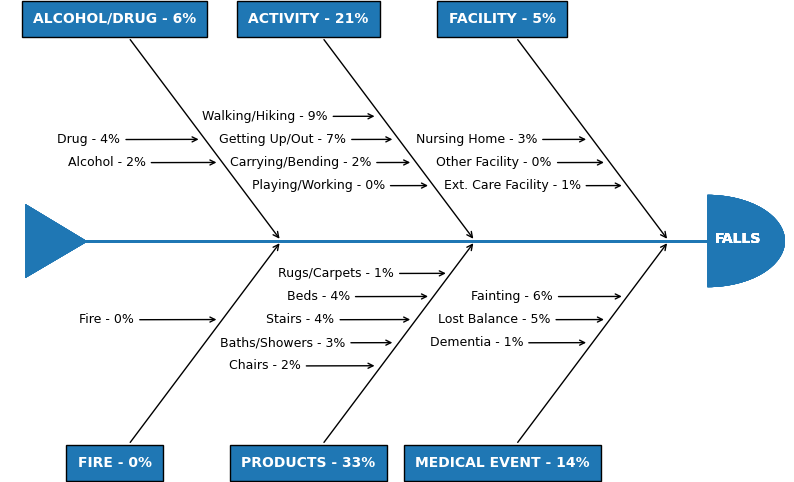

In [49]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.axis('off')

hispanic_df = df[df['hispanic'] == 'Yes']
hispanic_cats = create_categories(hispanic_df)

### Race Hispanic Falls - Top Ten Causes

In [50]:
hispanic_causes = convert(hispanic_cats)
hispanic_causes.head(10)

,cause,pct
0,Activity - Walking/Hiking,9
1,Activity - Getting Up/Out,7
2,Medical Event - Fainting,6
3,Medical Event - Lost Balance,5
4,Alcohol/Drug - Drug,4
5,Products - Stairs,4
6,Products - Beds,4
7,Facility - Nursing Home,3
8,Products - Baths/Showers,3
9,Alcohol/Drug - Alcohol,2


### Diagram Showing Causes of All Falls for Asians

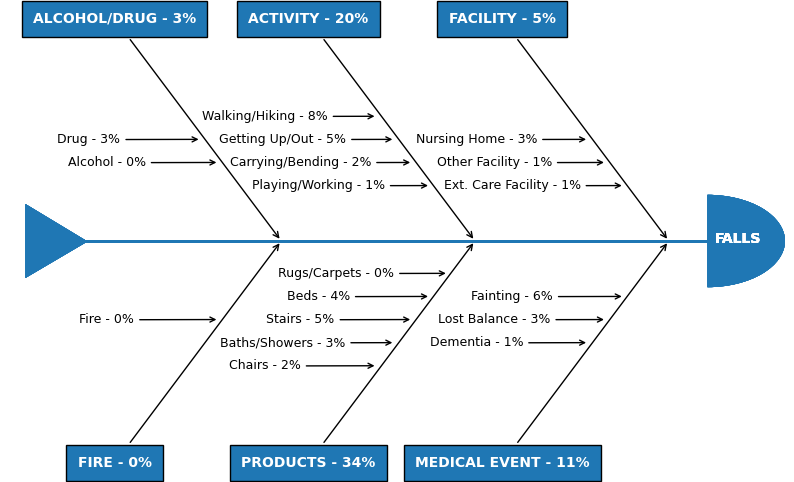

In [51]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.axis('off')

asian_df = df[df['race'] == 'ASIAN']
asian_cats = create_categories(asian_df)

### Race Asian Falls - Top Ten Causes

In [52]:
asian_causes = convert(asian_cats)
asian_causes.head(10)

,cause,pct
0,Activity - Walking/Hiking,8
1,Medical Event - Fainting,6
2,Activity - Getting Up/Out,5
3,Products - Stairs,5
4,Products - Beds,4
5,Products - Baths/Showers,3
6,Alcohol/Drug - Drug,3
7,Medical Event - Lost Balance,3
8,Facility - Nursing Home,3
9,Products - Chairs,2


### Diagram Showing Causes of All Falls for 2019

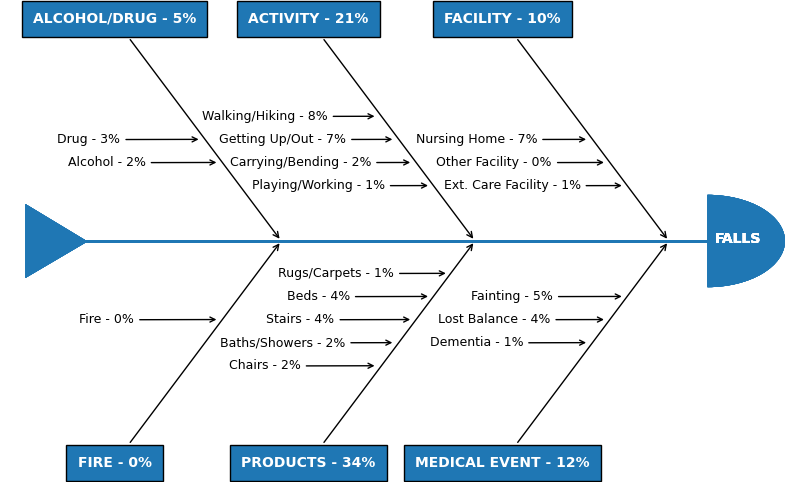

In [53]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.axis('off')

df['year'] = df['treatment_date'].str[:4]
df_2019 = df[df['year'] == '2019']
cats_2019 = create_categories(df_2019)

### Year 2019 Falls - Top Ten Causes

In [54]:
causes_2019 = convert(cats_2019)
causes_2019.head(10)

,cause,pct
0,Activity - Walking/Hiking,8
1,Activity - Getting Up/Out,7
2,Facility - Nursing Home,7
3,Medical Event - Fainting,5
4,Medical Event - Lost Balance,4
5,Products - Stairs,4
6,Products - Beds,4
7,Alcohol/Drug - Drug,3
8,Activity - Carrying/Bending,2
9,Products - Baths/Showers,2


### Diagram Showing Causes of All Falls for 2020

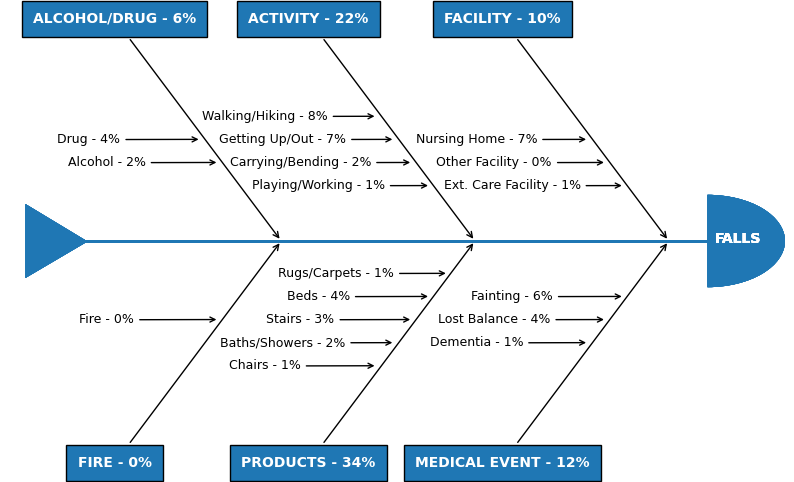

In [55]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.axis('off')

df_2020 = df[df['year'] == '2020']
cats_2020 = create_categories(df_2020)

### Year 2020 Falls - Top Ten Causes

In [56]:
causes_2020 = convert(cats_2020)
causes_2020.head(10)

,cause,pct
0,Activity - Walking/Hiking,8
1,Activity - Getting Up/Out,7
2,Facility - Nursing Home,7
3,Medical Event - Fainting,6
4,Alcohol/Drug - Drug,4
5,Medical Event - Lost Balance,4
6,Products - Beds,4
7,Products - Stairs,3
8,Activity - Carrying/Bending,2
9,Products - Baths/Showers,2


### Diagram Showing Causes of All Falls for 2021

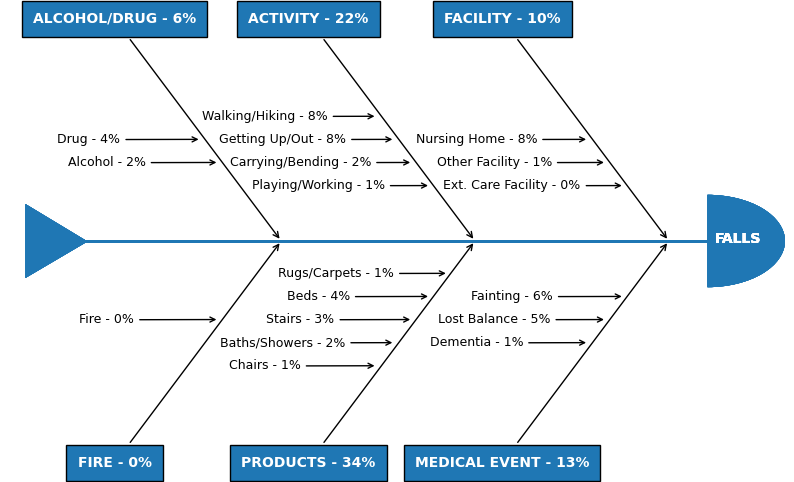

In [57]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.axis('off')

df_2021 = df[df['year'] == '2021']
cats_2021 = create_categories(df_2021)

### Year 2021 Falls - Top Ten Causes

In [58]:
causes_2021 = convert(cats_2021)
causes_2021.head(10)

,cause,pct
0,Activity - Walking/Hiking,8
1,Activity - Getting Up/Out,8
2,Facility - Nursing Home,8
3,Medical Event - Fainting,6
4,Medical Event - Lost Balance,5
5,Alcohol/Drug - Drug,4
6,Products - Beds,4
7,Products - Stairs,3
8,Alcohol/Drug - Alcohol,2
9,Activity - Carrying/Bending,2


### Diagram Showing Causes of All Falls for 2022

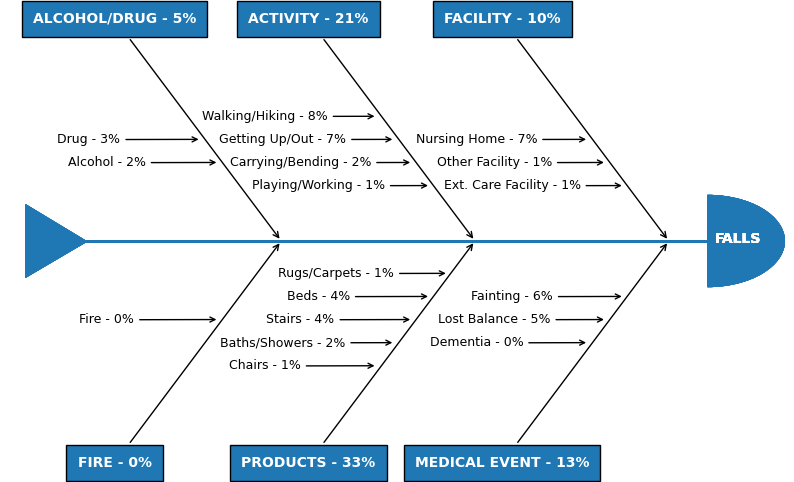

In [59]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.axis('off')

df_2022 = df[df['year'] == '2022']
cats_2022 = create_categories(df_2022)

### Year 2022 Falls - Top Ten Causes

In [60]:
causes_2022 = convert(cats_2022)
causes_2022.head(10)

,cause,pct
0,Activity - Walking/Hiking,8
1,Activity - Getting Up/Out,7
2,Facility - Nursing Home,7
3,Medical Event - Fainting,6
4,Medical Event - Lost Balance,5
5,Products - Stairs,4
6,Products - Beds,4
7,Alcohol/Drug - Drug,3
8,Alcohol/Drug - Alcohol,2
9,Activity - Carrying/Bending,2


## Summaries

The following summaries by type of fall (all falls, slips, trips, other falls and serious falls), falls by sex (male, female), falls by age (60-69, 70-79, 80-89, 90+), falls by race (white, black, hispanic, asian), and by falls by year (2019, 2020, 2021, 2022) provide the key findings for this analysis.

### Falls by Type - Top Ten Causes

As detailed above, the type of falls can be broken down to slips (15%), trips (16%) and other falls (67%). For slips, baths/showers play a prominent role when compared to the other types of falls. For trips, waking/hiking is the top cause with rugs/carpets also playing a prominent role. For all other falls, nursing homes are the top cause factor.  For serious falls (hospitalization), fainting is the top cause.

In [61]:
def highlight_cells(val):
    color = ''
    if type(val) == str:
        if 'Activity - Walking/Hiking' in val:
            color = 'lightgray'
        if 'Products - Baths/Showers' in val:
            color = 'lightskyblue'
        if 'Products - Rugs/Carpets' in val:
            color = 'gold'
        if 'Facility - Nursing Home' in val:
            color = 'lawngreen'
        if 'Medical Event - Fainting' in val:
            color = 'lightcoral'
    return 'background-color: {}'.format(color)

all_causes = all_causes.rename(columns={'cause': 'ALL CAUSES', 'pct': 'A PCT'})
all_causes['SLIP CAUSES'] = slip_causes['cause']
all_causes['S PCT'] = slip_causes['pct']
all_causes['TRIP CAUSES'] = trip_causes['cause']
all_causes['T PCT'] = trip_causes['pct']
all_causes['FALL CAUSES'] = fall_causes['cause']
all_causes['F PCT'] = fall_causes['pct']
all_causes['SERIOUS CAUSES'] = serious_causes['cause']
all_causes['R PCT'] = serious_causes['pct']

all_causes.head(10).style.map(highlight_cells)

,ALL CAUSES,A PCT,SLIP CAUSES,S PCT,TRIP CAUSES,T PCT,FALL CAUSES,F PCT,SERIOUS CAUSES,R PCT
0,Activity - Walking/Hiking,8,Activity - Walking/Hiking,8,Activity - Walking/Hiking,14,Facility - Nursing Home,9,Medical Event - Fainting,10
1,Activity - Getting Up/Out,7,Activity - Getting Up/Out,8,Activity - Getting Up/Out,4,Medical Event - Fainting,8,Activity - Getting Up/Out,9
2,Facility - Nursing Home,7,Facility - Nursing Home,5,Products - Stairs,4,Activity - Getting Up/Out,8,Activity - Walking/Hiking,7
3,Medical Event - Fainting,6,Alcohol/Drug - Drug,4,Alcohol/Drug - Drug,3,Activity - Walking/Hiking,7,Facility - Nursing Home,7
4,Medical Event - Lost Balance,5,Products - Baths/Showers,4,Products - Rugs/Carpets,3,Medical Event - Lost Balance,6,Alcohol/Drug - Drug,5
5,Alcohol/Drug - Drug,4,Products - Stairs,3,Activity - Carrying/Bending,2,Products - Beds,5,Medical Event - Lost Balance,4
6,Products - Stairs,4,Products - Beds,3,Facility - Nursing Home,2,Alcohol/Drug - Drug,3,Products - Beds,4
7,Products - Beds,4,Medical Event - Fainting,2,Products - Beds,1,Products - Stairs,3,Products - Stairs,3
8,Alcohol/Drug - Alcohol,2,Medical Event - Lost Balance,1,Alcohol/Drug - Alcohol,1,Alcohol/Drug - Alcohol,2,Products - Baths/Showers,2
9,Activity - Carrying/Bending,2,Alcohol/Drug - Alcohol,1,Products - Chairs,1,Activity - Carrying/Bending,2,Alcohol/Drug - Alcohol,2


### Falls by Sex - Top Ten Causes

Males experience more falls due to fainting than females.  Also, drug and alcohol are involved in more male falls.

In [62]:
def highlight_cells(val):
    color = ''
    if type(val) == str:
        if 'Medical Event - Fainting' in val:
            color = 'lightskyblue'
        if 'Alcohol/Drug' in val:
            color = 'gold'  
    return 'background-color: {}'.format(color)

male_causes = male_causes.rename(columns={'cause': 'MALE CAUSES', 'pct': 'M PCT'})
male_causes['FEMALE CAUSES'] = female_causes['cause']
male_causes['F PCT'] = female_causes['pct']

male_causes.head(10).style.map(highlight_cells)

,MALE CAUSES,M PCT,FEMALE CAUSES,F PCT
0,Activity - Walking/Hiking,8,Activity - Walking/Hiking,9
1,Medical Event - Fainting,7,Activity - Getting Up/Out,7
2,Activity - Getting Up/Out,7,Facility - Nursing Home,7
3,Facility - Nursing Home,7,Medical Event - Lost Balance,5
4,Alcohol/Drug - Drug,5,Medical Event - Fainting,5
5,Products - Beds,4,Products - Beds,4
6,Medical Event - Lost Balance,4,Alcohol/Drug - Drug,3
7,Products - Stairs,4,Products - Stairs,3
8,Alcohol/Drug - Alcohol,3,Activity - Carrying/Bending,2
9,Activity - Carrying/Bending,2,Products - Baths/Showers,2


### Falls by Age - Top Ten Causes

The involvement of nursing homes in falls increases significantly once people reach their 80's.  Interestingly, alcohol plays a prominent role in falls in the 60's but drops significantly once people reach their 70's.

In [63]:
def highlight_cells(val):
    color = ''
    if type(val) == str:
        if 'Facility - Nursing Home' in val:
            color = 'lightskyblue'
        if 'Alcohol/Drug - Alcohol' in val:
            color = 'gold'  
    return 'background-color: {}'.format(color)

causes_60_69 = causes_60_69.rename(columns={'cause': 'AGE 60-69 CAUSES', 'pct': '60s PCT'})
causes_60_69['AGE 70-79 CAUSES'] = causes_70_79['cause']
causes_60_69['70s PCT'] = causes_70_79['pct']
causes_60_69['AGE 80-89 CAUSES'] = causes_80_89['cause']
causes_60_69['80s PCT'] = causes_80_89['pct']
causes_60_69['AGE 90+ CAUSES'] = causes_90['cause']
causes_60_69['90s PCT'] = causes_90['pct']

causes_60_69.head(10).style.map(highlight_cells)

,AGE 60-69 CAUSES,60s PCT,AGE 70-79 CAUSES,70s PCT,AGE 80-89 CAUSES,80s PCT,AGE 90+ CAUSES,90s PCT
0,Activity - Walking/Hiking,9,Activity - Walking/Hiking,9,Facility - Nursing Home,9,Facility - Nursing Home,17
1,Medical Event - Fainting,7,Activity - Getting Up/Out,7,Activity - Walking/Hiking,8,Activity - Getting Up/Out,9
2,Alcohol/Drug - Alcohol,5,Medical Event - Fainting,6,Activity - Getting Up/Out,8,Activity - Walking/Hiking,6
3,Activity - Getting Up/Out,5,Medical Event - Lost Balance,4,Medical Event - Fainting,6,Medical Event - Lost Balance,6
4,Products - Stairs,5,Facility - Nursing Home,4,Medical Event - Lost Balance,5,Products - Beds,6
5,Alcohol/Drug - Drug,3,Products - Stairs,4,Products - Beds,4,Alcohol/Drug - Drug,4
6,Medical Event - Lost Balance,3,Products - Beds,4,Alcohol/Drug - Drug,4,Medical Event - Fainting,3
7,Products - Beds,3,Alcohol/Drug - Drug,3,Products - Stairs,3,Products - Chairs,2
8,Activity - Carrying/Bending,2,Alcohol/Drug - Alcohol,2,Activity - Carrying/Bending,2,Products - Baths/Showers,2
9,Activity - Playing/Working,2,Activity - Carrying/Bending,2,Products - Chairs,2,Facility - Other Facility,2


### Falls by Race - Top Ten Causes

Fainting plays a more prominent role in non-white races while nursing homes play a more prominent role in whites.

In [64]:
def highlight_cells(val):
    color = ''
    if type(val) == str:
        if 'Medical Event - Fainting' in val:
            color = 'lightskyblue'
        if 'Facility - Nursing Home' in val:
            color = 'gold'  
    return 'background-color: {}'.format(color)

white_causes = white_causes.rename(columns={'cause': 'WHITE CAUSES', 'pct': 'W PCT'})
white_causes['BLACK CAUSES'] = black_causes['cause']
white_causes['B PCT'] = black_causes['pct']
white_causes['HISPANIC CAUSES'] = hispanic_causes['cause']
white_causes['H PCT'] = hispanic_causes['pct']
white_causes['ASIAN CAUSES'] = asian_causes['cause']
white_causes['A PCT'] = asian_causes['pct']

white_causes.head(10).style.map(highlight_cells)

,WHITE CAUSES,W PCT,BLACK CAUSES,B PCT,HISPANIC CAUSES,H PCT,ASIAN CAUSES,A PCT
0,Activity - Walking/Hiking,8,Activity - Walking/Hiking,8,Activity - Walking/Hiking,9,Activity - Walking/Hiking,8
1,Activity - Getting Up/Out,7,Medical Event - Fainting,8,Activity - Getting Up/Out,7,Medical Event - Fainting,6
2,Facility - Nursing Home,6,Activity - Getting Up/Out,7,Medical Event - Fainting,6,Activity - Getting Up/Out,5
3,Medical Event - Lost Balance,5,Products - Beds,6,Medical Event - Lost Balance,5,Products - Stairs,5
4,Medical Event - Fainting,5,Facility - Nursing Home,5,Alcohol/Drug - Drug,4,Products - Beds,4
5,Alcohol/Drug - Drug,4,Products - Stairs,5,Products - Stairs,4,Products - Baths/Showers,3
6,Products - Stairs,4,Medical Event - Lost Balance,3,Products - Beds,4,Alcohol/Drug - Drug,3
7,Products - Beds,4,Alcohol/Drug - Alcohol,3,Facility - Nursing Home,3,Medical Event - Lost Balance,3
8,Alcohol/Drug - Alcohol,2,Products - Baths/Showers,3,Products - Baths/Showers,3,Facility - Nursing Home,3
9,Activity - Carrying/Bending,2,Alcohol/Drug - Drug,2,Alcohol/Drug - Alcohol,2,Products - Chairs,2


### Falls by Year - Top Ten Causes

The causes of falls are fairly consistent over time with a bump in drug involvement in 2020 and 2021.

In [65]:
def highlight_cells(val):
    color = ''
    if type(val) == str:
        if 'Alcohol/Drug - Drug' in val:
            color = 'lightskyblue'
    return 'background-color: {}'.format(color)

causes_2019 = causes_2019.rename(columns={'cause': '2019 CAUSES', 'pct': '2019 PCT'})
causes_2019['2020 CAUSES'] = causes_2020['cause']
causes_2019['2020 PCT'] = causes_2020['pct']
causes_2019['2021 CAUSES'] = causes_2021['cause']
causes_2019['2021 PCT'] = causes_2021['pct']
causes_2019['2022 CAUSES'] = causes_2022['cause']
causes_2019['2022 PCT'] = causes_2022['pct']

causes_2019.head(10).style.map(highlight_cells)

,2019 CAUSES,2019 PCT,2020 CAUSES,2020 PCT,2021 CAUSES,2021 PCT,2022 CAUSES,2022 PCT
0,Activity - Walking/Hiking,8,Activity - Walking/Hiking,8,Activity - Walking/Hiking,8,Activity - Walking/Hiking,8
1,Activity - Getting Up/Out,7,Activity - Getting Up/Out,7,Activity - Getting Up/Out,8,Activity - Getting Up/Out,7
2,Facility - Nursing Home,7,Facility - Nursing Home,7,Facility - Nursing Home,8,Facility - Nursing Home,7
3,Medical Event - Fainting,5,Medical Event - Fainting,6,Medical Event - Fainting,6,Medical Event - Fainting,6
4,Medical Event - Lost Balance,4,Alcohol/Drug - Drug,4,Medical Event - Lost Balance,5,Medical Event - Lost Balance,5
5,Products - Stairs,4,Medical Event - Lost Balance,4,Alcohol/Drug - Drug,4,Products - Stairs,4
6,Products - Beds,4,Products - Beds,4,Products - Beds,4,Products - Beds,4
7,Alcohol/Drug - Drug,3,Products - Stairs,3,Products - Stairs,3,Alcohol/Drug - Drug,3
8,Activity - Carrying/Bending,2,Activity - Carrying/Bending,2,Alcohol/Drug - Alcohol,2,Alcohol/Drug - Alcohol,2
9,Products - Baths/Showers,2,Products - Baths/Showers,2,Activity - Carrying/Bending,2,Activity - Carrying/Bending,2
